In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
#default_exp callback.mixup

In [ ]:
#export
from fastai.basics import *
from torch.distributions.beta import Beta

In [ ]:
#hide
from nbdev.showdoc import *
from fastai.test_utils import *

# MixUp and Friends

> Callbacks that can apply the MixUp (and variants) data augmentation to your training

In [ ]:
#export
def reduce_loss(loss, reduction='mean'):
    "Reduce the loss based on `reduction`"
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

In [ ]:
#export
class MixHandler(Callback):
    "A handler class for implementing `MixUp` style scheduling"
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=0.5): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def before_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf
            
    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

Most `Mix` variants will perform the data augmentation on the batch, so to implement your `Mix` you should adjust the `before_batch` event with however your training regiment requires. If it requires a custom loss function you should also override the `lf` event.

In [ ]:
#export
class MixUp(MixHandler):
    "Implementation of https://arxiv.org/abs/1710.09412"
    def __init__(self, alpha=.4): super().__init__(alpha)
    def before_batch(self):
        lam = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))
        
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

First we'll look at a very minimalistic example to show how our data is being generated with the `PETS` dataset:

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.PETS)
pat        = r'([^/]+)_\d+.*$'
fnames     = get_image_files(path/'images')
item_tfms  = [Resize(256, method='crop')]
batch_tfms = [*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
dls = ImageDataLoaders.from_name_re(path, fnames, pat, bs=64, item_tfms=item_tfms, 
                                    batch_tfms=batch_tfms)

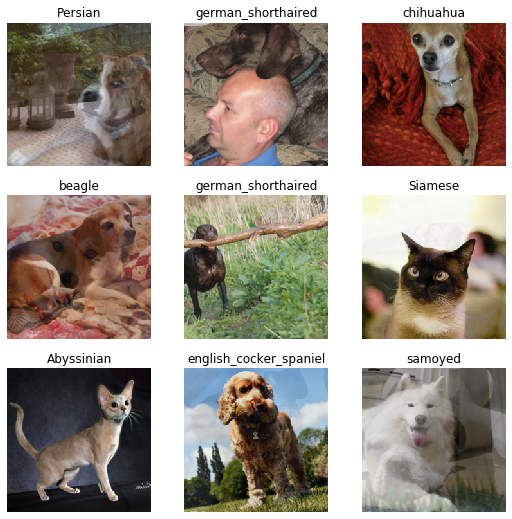

In [ ]:
mixup = MixUp(0.5)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

We can see that every so often an image gets "mixed" with another. 

How do we train? You should pass the `Callback` into your `fit`, so its not tied to your `Learner` 
> This can avoid headaches on inference, when we don't want `MixUp` to be run

In [ ]:
#slow
learn = cnn_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, error_rate])
learn.fit_one_cycle(1, cbs=mixup)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.527094,0.528015,0.847767,0.152233,00:22


In [ ]:
#export
class CutMix(MixHandler):
    "Implementation of `https://arxiv.org/abs/1905.04899`"
    def __init__(self, alpha=1.): super().__init__(alpha)
    def before_batch(self):
        W, H = self.xb[0].size(3), self.xb[0].size(2)
        lam = self.distrib.sample((1,)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam])
        self.lam = lam.max()
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        self.learn.xb[0][:, :, x1:x2, y1:y2] = xb1[0][:, :, x1:x2, y1:y2]
        self.lam = (1 - ((x2-x1)*(y2-y1))/float(W*H)).item()
        
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))
            
    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = (W * cut_rat).type(torch.long)
        cut_h = (H * cut_rat).type(torch.long)
        # uniform
        cx = torch.randint(0, W, (1,)).to(self.x.device)
        cy = torch.randint(0, H, (1,)).to(self.x.device)
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1, y1, x2, y2

Similar to `MixUp`, `CutMix` will cut a random box out of two images and swap them together. We can look at a few examples below:

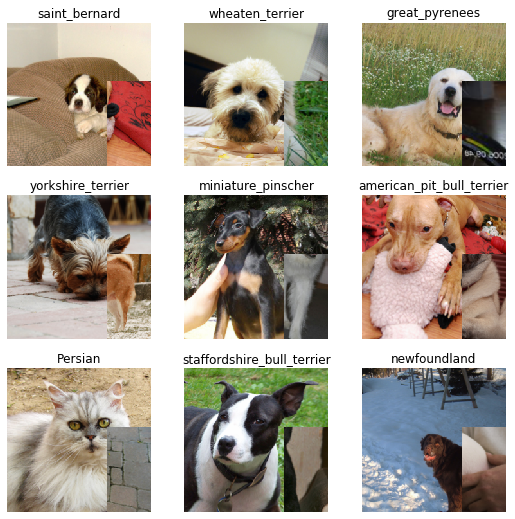

In [ ]:
cutmix = CutMix(1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

We train with it in the exact same way as well

In [ ]:
#slow
learn = cnn_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, error_rate])
learn.fit_one_cycle(1, cbs=cutmix)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.863441,0.531368,0.840325,0.159675,00:21


# Export - 

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()